# Analysis by using a second video

In [198]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import pandas as pd
import toml

In [199]:
_working_dir = os.path.abspath('../../')
_data_dir = "data"
_fov = 160
_working_dir

'e:\\CMC\\pyprojects\\programs_rpi\\rpi_python'

# Calibration path

In [200]:
_calibration_folder = 'calib_mono_160fov_raw'
_calibration_folder = os.path.join(_data_dir, "calibration", f"{_fov}_fov", _calibration_folder)
_calibration_file_path = os.path.join(_working_dir, _calibration_folder, 'webcam_color.msgpack')
_calibration_file_path

'e:\\CMC\\pyprojects\\programs_rpi\\rpi_python\\data\\calibration\\160_fov\\calib_mono_160fov_raw\\webcam_color.msgpack'

In [201]:
# Alternatively import calibration parameters from toml file
_toml_pth = os.path.join(_working_dir, 'improved_fisheye_calibration_optimal.toml')
_toml_pth

'e:\\CMC\\pyprojects\\programs_rpi\\rpi_python\\improved_fisheye_calibration_optimal.toml'

# Movement data path / April tag recording path

In [202]:

_folder_name = 'randomxyz_t0'
_semi_parent = '3marker_complete_data'

_recording_folder = os.path.join(_working_dir,_data_dir, "recordings",f'{_fov}_fov', _semi_parent, _folder_name)
_movement_data_path = os.path.join(_recording_folder, 'webcam_color.msgpack')



In [203]:
_ref_video_length = 0

for _ in mp.Unpacker(open(_movement_data_path, "rb"), object_hook=mpn.decode):
    _ref_video_length += 1

print('video length, ', _ref_video_length)

video length,  2861


In [204]:
timestamp_file = os.path.join(_recording_folder, 'webcam_timestamp.msgpack')
_ar_timestamp = list(mp.Unpacker(open(timestamp_file, "rb"), object_hook=mpn.decode))
# _ar_timestamp = np.array(_ar_timestamp)

In [205]:
_sync = np.array(_ar_timestamp).T[0]
_sync = _sync.astype(int)
_timestamps = np.array(_ar_timestamp).T[1]

In [206]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36h11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients = np.zeros((5, 1))
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs, tvecs = [], []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            flags=cv2.SOLVEPNP_ITERATIVE,
        )
        if r is not None and t is not None:
            rvecs.append(r.reshape(1, 3).tolist())
            tvecs.append(t.reshape(1, 3).tolist())
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

## load clalibration data

In [207]:
# _calib_data = list(mp.Unpacker(open(_calibration_data, "rb"), object_hook=mpn.decode))

In [208]:
_calib_data = toml.load(_toml_pth)

matrix = np.array(_calib_data['calibration']['camera_matrix'], dtype=np.float32).reshape(3, 3)
distortion = np.array(_calib_data['calibration']['dist_coeffs'], dtype=np.float32)

In [209]:
# _calib_data

_new_matrix = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
    matrix, distortion, (1200, 800), np.eye(3))
_new_matrix

array([[1.2000002e-03, 0.0000000e+00, 1.2000001e+03],
       [0.0000000e+00, 1.1980050e-03, 9.9999994e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [210]:
def undistort_aruco_corners_fisheye(corners, camera_matrix, dist_coeffs):
    """
    Undistort ArUco corners using fisheye camera model.
    
    Args:
        corners: List of corner arrays from ArUco detection
        camera_matrix: Original fisheye camera matrix
        dist_coeffs: Fisheye distortion coefficients
    
    Returns:
        undistorted_corners: List of undistorted corner arrays
    """
    if corners is None or len(corners) == 0:
        return corners
    
    undistorted_corners = []
    
    for corner_set in corners:
        # Reshape corners to the format expected by undistortPoints
        corner_points = corner_set.reshape(-1, 1, 2).astype(np.float32)
        
        # Undistort using fisheye model
        undistorted_points = cv2.fisheye.undistortPoints(
            corner_points,
            camera_matrix,
            dist_coeffs,
            P=camera_matrix
        )
        
        # Reshape back to original format
        undistorted_corner_set = undistorted_points.reshape(corner_set.shape)
        undistorted_corners.append(undistorted_corner_set)
    
    return undistorted_corners

In [211]:

ar_total_results = {'calib_idx':[], 'ar_data':[]}
ar_results = {'corners': [], 'ids': [], 'rejected': [], 'rvecs': [], 'tvecs': []}
vector_std = {'v1std':[], 'v2std':[], 'v3std':[], 'sum':[]}


_frames = mp.Unpacker(open(_movement_data_path, "rb"), object_hook=mpn.decode)

for idx, _frame in tqdm(enumerate(_frames)):
    # _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    _frame = cv2.flip(_frame, 1)
    res = detector.detectMarkers(_frame,)
    
    res = detector.refineDetectedMarkers(_frame, board, res[0], res[1], res[2])
    
    corners = undistort_aruco_corners_fisheye(res[0], matrix, distortion)
    
    # res[0] = cv2.undistortPoints(
    #     res[0], matrix, distortion, P=_new_matrix)
    
    ar_results['corners'].append(corners)
    ar_results['ids'].append(res[1].T.reshape(-1))
    ar_results['rejected'].append(res[2])
    
    if res[0] is not None and len(res[0]) > 0:
        rvecs, tvecs = estimate_pose_single_markers(
            corners, markerLength, matrix, distortion
        )
        
        # rvecs, tvecs = estimate_pose_single_markers(
        #     res[0], markerLength, _new_matrix, np.zeros((5, 1))
        # )
        
        ar_results['rvecs'].append(rvecs)
        ar_results['tvecs'].append(tvecs)
    
    # if idx in _random_reference_frames_idx:
    #     _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    #     _ref_frames.append(_frame)


0it [00:00, ?it/s]

In [212]:
ar_results['ids'][0]

array([12, 20, 14], dtype=int32)

In [213]:
import numpy as np
import cv2

# Initialize the dictionary to store transformed translation vectors
transformed_tvec = {'12': [], '14': [], '20': []}
target_ids = [12, 14, 20]  # IDs we're interested in

for _id in range(len(ar_results['ids'])):
    sorted_ids = np.sort(ar_results['ids'][_id])
    sorted_id_index = np.argsort(ar_results['ids'][_id])
    _corners = np.array(ar_results['corners'][_id])[sorted_id_index]
    _rvecs = ar_results['rvecs'][_id][sorted_id_index]
    _tvecs = ar_results['tvecs'][_id][sorted_id_index]
   
    if _id == 0:
        # Store initial reference frame (assuming first detected marker)
        initial_rmat = cv2.Rodrigues(_rvecs[0])[0]
        initial_tvec = _tvecs[0]
    else:
        # Transform all detected markers to reference frame
        _temp_vec = _tvecs.reshape(-1, 3).T - initial_tvec.reshape(-1, 3).T
        _temp = (initial_rmat.T @ _temp_vec).T
        
        # Create a mapping from detected IDs to their transformed positions
        id_to_position = {}
        for i, marker_id in enumerate(sorted_ids):
            id_to_position[marker_id] = _temp[i]
        
        # For each target ID, append the transformed position or NaN if not detected
        for target_id in target_ids:
            if target_id in id_to_position:
                transformed_tvec[str(target_id)].append(id_to_position[target_id])
            else:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))

# Alternative approach using a more flexible data structure
def process_aruco_detections(ar_results, target_ids=[12, 14, 20]):
    """
    Process ArUco detection results, handling missing IDs gracefully.
    
    Args:
        ar_results: Dictionary containing 'ids', 'corners', 'rvecs', 'tvecs'
        target_ids: List of marker IDs we want to track
    
    Returns:
        Dictionary with transformed translation vectors for each target ID
    """
    transformed_tvec = {str(tid): [] for tid in target_ids}
    initial_rmat = None
    initial_tvec = None
    
    for frame_idx in range(len(ar_results['ids'])):
        if ar_results['ids'][frame_idx] is None or len(ar_results['ids'][frame_idx]) == 0:
            # No markers detected in this frame
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
            
        # Sort detections by ID for consistency
        sorted_indices = np.argsort(ar_results['ids'][frame_idx])
        sorted_ids = ar_results['ids'][frame_idx][sorted_indices]
        sorted_rvecs = ar_results['rvecs'][frame_idx][sorted_indices]
        sorted_tvecs = ar_results['tvecs'][frame_idx][sorted_indices]
        
        # Initialize reference frame from first detection
        if initial_rmat is None:
            initial_rmat = cv2.Rodrigues(sorted_rvecs[0])[0]
            initial_tvec = sorted_tvecs[0]
            # For the first frame, just fill with NaN (or zeros if preferred)
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
        
        # Transform all detected markers to reference frame
        temp_vec = sorted_tvecs.reshape(-1, 3).T - initial_tvec.reshape(-1, 3).T
        transformed_positions = (initial_rmat.T @ temp_vec).T
        
        # Create mapping from ID to transformed position
        id_to_position = dict(zip(sorted_ids, transformed_positions))
        
        # Append results for each target ID
        for target_id in target_ids:
            if target_id in id_to_position:
                transformed_tvec[str(target_id)].append(id_to_position[target_id])
            else:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
    
    return transformed_tvec

# Usage example:
# transformed_tvec = process_aruco_detections(ar_results, target_ids=[12, 14, 20])

# For handling NaN values later in your analysis:
def clean_transformed_data(transformed_tvec):
    """Remove NaN entries and return valid data points with their indices."""
    cleaned_data = {}
    for marker_id, positions in transformed_tvec.items():
        positions_array = np.array(positions)
        # Find rows where all values are not NaN
        valid_mask = ~np.isnan(positions_array).all(axis=1)
        cleaned_data[marker_id] = {
            'positions': positions_array[valid_mask],
            'frame_indices': np.where(valid_mask)[0]
        }
    return cleaned_data

In [214]:
transformed_tvec = process_aruco_detections(ar_results, target_ids=[12, 14, 20])
transformed_tvec = clean_transformed_data(transformed_tvec)

In [215]:
len(_timestamps), len(transformed_tvec['12']['positions']), 

(2861, 2860)

In [216]:
_start_pulse = 0
_end_pulse = 0
for idx, _s in enumerate(_sync):
    if _s == 1:
        _start_pulse = idx
        break
for idx, _s in enumerate(_sync[_start_pulse:]):
    if _s == 0:
        _end_pulse = idx
        break


In [217]:
_time_df = pd.DataFrame({
    'time': _timestamps[:len(transformed_tvec['12']['positions'])],
    '12_x': transformed_tvec['12']['positions'][:, 0],
    '12_y': transformed_tvec['12']['positions'][:, 1],
    '12_z': transformed_tvec['12']['positions'][:, 2],
    # '14_x': transformed_tvec['14']['positions'][:, 0],
    # '14_y': transformed_tvec['14']['positions'][:, 1],
    # '14_z': transformed_tvec['14']['positions'][:, 2],
    # '20_x': transformed_tvec['20']['positions'][:, 0],
    # '20_y': transformed_tvec['20']['positions'][:, 1],
    # '20_z': transformed_tvec['20']['positions'][:, 2],
})
# convert time column to datetime
_time_df['time'] = pd.to_datetime(_time_df['time'])
# _time_df = _time_df[_start_pulse:_end_pulse].reset_index()
_time_df = _time_df[_start_pulse:].reset_index()

# mocap path

In [218]:
import sys
sys.path.insert(1, os.path.dirname(os.getcwd()))
from pd_support import *
_mocap_pth = os.path.join(os.path.dirname(_movement_data_path), f"{_folder_name}.csv")

mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
mocap_df = add_datetime_col(mocap_df, st_time, 'seconds')


_time_offset = _time_df['time'][0] - mocap_df['time'][0]

_time_df['time'] = _time_df['time'] - _time_offset

e:\CMC\pyprojects\programs_rpi\rpi_python\notebooks\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [219]:
rb_quat = mocap_df[['rb_ang_x', 'rb_ang_y', 'rb_ang_z', 'rb_ang_w']].values
rb_pos = mocap_df[['rb_pos_x', 'rb_pos_y', 'rb_pos_z']].values

In [220]:
from scipy.spatial.transform import Rotation as R
rb_matrix = R.from_quat(rb_quat[0]).as_matrix()

In [221]:
transformed_rb_pos = (rb_matrix.T @ (rb_pos.T - rb_pos[0].reshape(3,1))).T
rotation_correction = R.from_euler('xyz', [90, 0, 0], degrees=True).as_matrix()
transformed_rb_pos = (rotation_correction.T @ transformed_rb_pos.T).T

# Interpolation

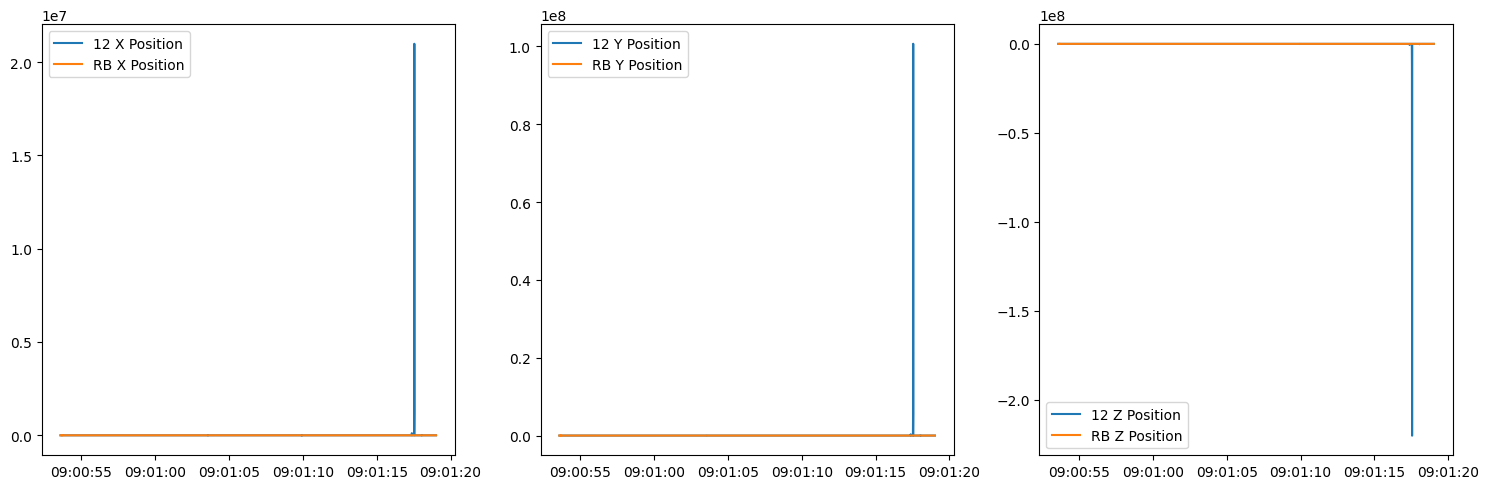

In [222]:
from scipy.interpolate import interp1d

_cols = ['12_x', '12_y', '12_z']

_ar_df = pd.DataFrame()
for _col in _cols:
    _interp_func = interp1d(
        _time_df['time'].astype(np.int64), 
        _time_df[_col], 
        bounds_error=False, 
        fill_value='extrapolate'
    )
    
    _ar_df[_col] = _interp_func(mocap_df['time'].astype(np.int64))
    
# 3, 1 subplot 

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

# Plot X positions
plt.plot(mocap_df['time'], -1*_ar_df['12_x'], label='12 X Position')
plt.plot(mocap_df['time'], transformed_rb_pos.T[0], label='RB X Position')
plt.legend()
plt.subplot(1, 3, 2)
# Plot Y positions
plt.plot(mocap_df['time'], _ar_df['12_y'], label='12 Y Position')
plt.plot(mocap_df['time'], transformed_rb_pos.T[1], label='RB Y Position')
plt.legend()
plt.subplot(1, 3, 3)
# Plot Z positions
plt.plot(mocap_df['time'], -_ar_df['12_z'], label='12 Z Position')
plt.plot(mocap_df['time'], transformed_rb_pos.T[2], label='RB Z Position')
plt.legend()
plt.tight_layout()

# Error plots

In [223]:
error_df = pd.DataFrame({
    '12_x': np.abs(-1*_ar_df['12_x'] - transformed_rb_pos.T[0])
    , '12_y': np.abs(_ar_df['12_y'] - transformed_rb_pos.T[1])
    , '12_z': np.abs(-_ar_df['12_z'] - transformed_rb_pos.T[2])
})

<Axes: >

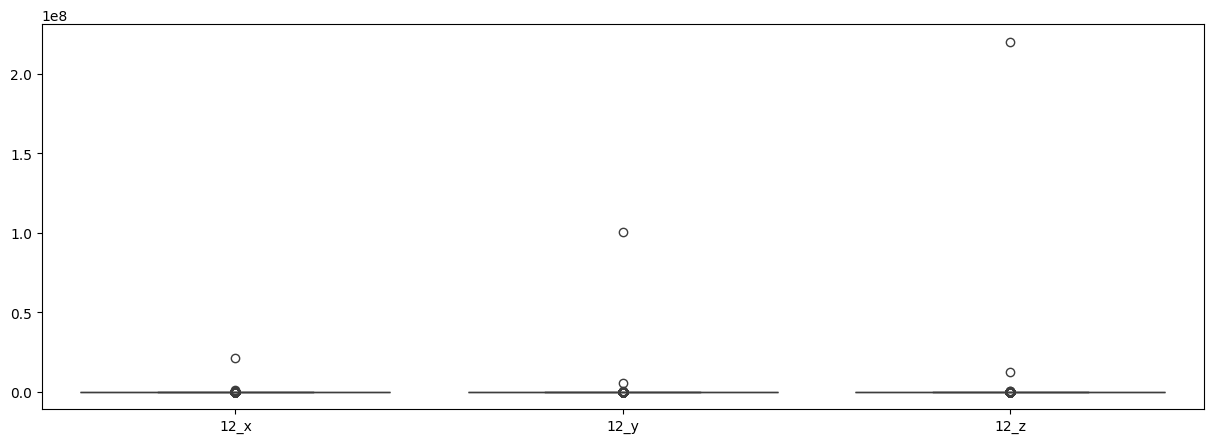

In [224]:
# error box plots
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.boxplot(data=error_df)

